In [1]:
from pathlib import Path
from typing import List
from loguru import logger
from tqdm.notebook import tqdm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random
import numpy as np
import wespeaker
import json

from pydub import AudioSegment
import wave
import contextlib

from speech_users_db import SpeechUsersDB

SEED = 42

In [2]:
AUDIO_DIR = Path("../data/audio/")
SPEECH_DATA_DIR = Path("../data/speech/")
SPEECH_PLOTS_DIR = Path("../plots/speech/")
CONCAT_VID_AUDIO_DIR = SPEECH_DATA_DIR / "concat_audio"

## Concatenated 100

In [3]:
# def concat_wavs(filepaths: List[str], out: str):
#     """
#     Concatenates multiple .wav files with handling different sample rates, channels, and sample widths.

#     Args:
#     files (list of str): List of file paths to .wav files to be concatenated.
#     output_file (str): Path where the concatenated .wav file will be saved.
#     """
#     # Load the first audio file
#     result = AudioSegment.from_file(filepaths[0])

#     # Append each subsequent file
#     for file in filepaths[1:]:
#         next_audio = AudioSegment.from_file(file)
#         result += next_audio

#     # Export the concatenated result
#     result.export(out, format="wav")

In [4]:
# for speaker_id_dir in tqdm(list(AUDIO_DIR.iterdir())):
#     speaker_id = speaker_id_dir.name
#     for video_id_dir in speaker_id_dir.iterdir():
#         video_id = video_id_dir.stem
#         audio_files = list(video_id_dir.glob("*.wav"))
#         if len(audio_files) == 0:
#             logger.warning(f"No audio files found in {video_id_dir}!")
#             continue
#         audio_files.sort()
        
#         concatenated_wav_fpath = CONCAT_VID_AUDIO_DIR / speaker_id / f"{video_id}.wav"
#         concatenated_wav_fpath.parent.mkdir(parents=True, exist_ok=True)

#         concat_wavs(audio_files, out=str(concatenated_wav_fpath))

### EDA

In [5]:
def retrieve_wav_info(file_path):
    """
    Retrieves information from a WAV file.

    Args:
    file_path (str): Path to the WAV file.

    Returns:
    dict: A dictionary containing the file's sample width, frame rate, channels, number of frames, and duration.
    """
    with contextlib.closing(wave.open(file_path, 'rb')) as wav_file:
        # Extract parameters
        channels = wav_file.getnchannels()
        sampwidth = wav_file.getsampwidth()
        framerate = wav_file.getframerate()
        nframes = wav_file.getnframes()
        duration = nframes / float(framerate)

        # Create a dictionary with the parameters
        info = {
            'channels': channels,
            'sample_width': sampwidth,
            'frame_rate': framerate,
            'number_of_frames': nframes,
            'duration_seconds': duration
        }

        return info

In [6]:
concatenated_wav_metadata = []
for speaker_id_dir in tqdm(list(CONCAT_VID_AUDIO_DIR.iterdir())):
    speaker_id = speaker_id_dir.name
    for video_wav_fpath in speaker_id_dir.iterdir():
        video_id = video_wav_fpath.stem
        vid_metadata = {"speaker_id": speaker_id, "video_id": video_id, "format": "wav"}
        vid_info = retrieve_wav_info(str(video_wav_fpath))
        vid_metadata.update(vid_info)
        concatenated_wav_metadata.append(vid_metadata)

  0%|          | 0/99 [00:00<?, ?it/s]

In [7]:
dataset_df = pd.DataFrame.from_records(concatenated_wav_metadata)
dataset_df["VideoFpath"] = dataset_df.apply(lambda x: str(CONCAT_VID_AUDIO_DIR / x["speaker_id"] / f"{x['video_id']}.wav"), axis=1)
dataset_df.to_csv(SPEECH_DATA_DIR / "concat_audio_df.csv", index=False)
dataset_df

,speaker_id,video_id,format,channels,sample_width,frame_rate,number_of_frames,duration_seconds,VideoFpath
0,id41102,HoPP5mYWyxY,wav,2,2,16000,654720,40.92,../data/speech/concat_audio/id41102/HoPP5mYWyx...
1,id41102,4DV8YuFjrNk,wav,2,2,16000,140800,8.80,../data/speech/concat_audio/id41102/4DV8YuFjrN...
2,id41102,1K1Nd9h3e1I,wav,2,2,16000,712320,44.52,../data/speech/concat_audio/id41102/1K1Nd9h3e1...
3,id41102,k5CC_ZzGR-Q,wav,2,2,16000,229120,14.32,../data/speech/concat_audio/id41102/k5CC_ZzGR-...
4,id41102,P63okDJgrJE,wav,2,2,16000,378240,23.64,../data/speech/concat_audio/id41102/P63okDJgrJ...
...,...,...,...,...,...,...,...,...,...
1116,id34371,QJ_Bgup5PkE,wav,2,2,16000,36480,2.28,../data/speech/concat_audio/id34371/QJ_Bgup5Pk...
1117,id34371,O1X-s1Lq5ag,wav,2,2,16000,40960,2.56,../data/speech/concat_audio/id34371/O1X-s1Lq5a...
1118,id34371,AsnNeQxfmIE,wav,2,2,16000,19840,1.24,../data/speech/concat_audio/id34371/AsnNeQxfmI...
1119,id34371,-b7kZx51oi0,wav,2,2,16000,40320,2.52,../data/speech/concat_audio/id34371/-b7kZx51oi...


In [8]:
random_audio_clip = dataset_df.sample()
assert (CONCAT_VID_AUDIO_DIR / random_audio_clip["speaker_id"].item() / f"{random_audio_clip['video_id'].item()}.wav").exists()

In [9]:
dataset_df["speaker_id"].nunique()

99

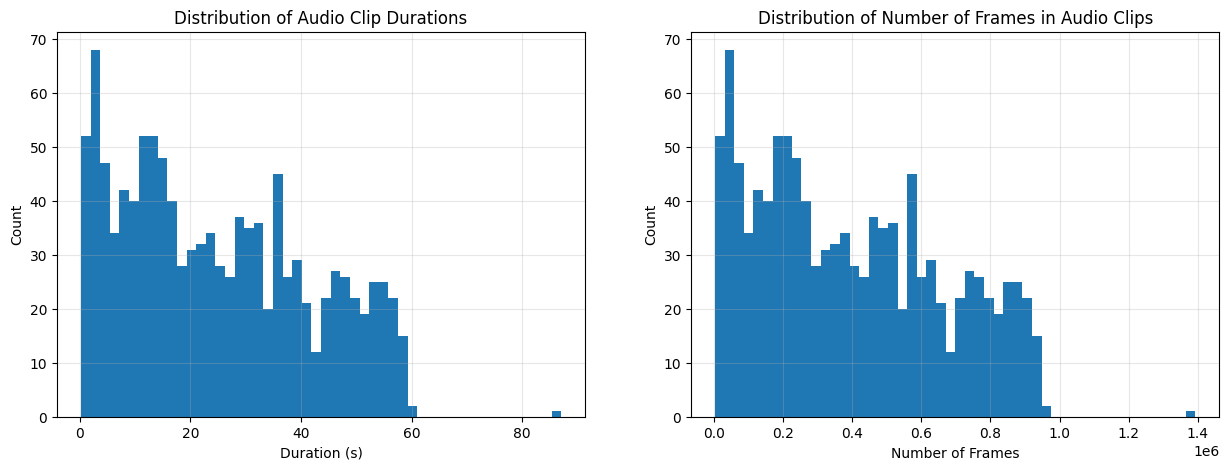

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

dataset_df["duration_seconds"].hist(bins=50, ax=ax1)
ax1.set_title("Distribution of Audio Clip Durations")
ax1.set_xlabel("Duration (s)")
ax1.set_ylabel("Count")
ax1.grid(alpha=0.3)

dataset_df["number_of_frames"].hist(bins=50, ax=ax2)
ax2.set_title("Distribution of Number of Frames in Audio Clips")
ax2.set_xlabel("Number of Frames")
ax2.set_ylabel("Count")
ax2.grid(alpha=0.3)

fig.savefig(SPEECH_PLOTS_DIR / "concat_audio_metadata.png")

### Registration DF

In [11]:
registration_df = dataset_df.groupby("speaker_id").sample(1, random_state=SEED).reset_index(drop=True)

# mac_jed = pd.DataFrame({"image": ['mac1.jpg', 'jed1.jpg'], "speaker_id": ["mac", "jed"]})
# registration_df = pd.concat([registration_df, mac_jed], ignore_index=True)

registration_df.to_csv(SPEECH_DATA_DIR / "concat_audio_registration_df.csv", index=False)

registration_df = pd.read_csv(SPEECH_DATA_DIR / "concat_audio_registration_df.csv")

registration_df

,speaker_id,video_id,format,channels,sample_width,frame_rate,number_of_frames,duration_seconds,VideoFpath
0,id00694,IgUtEqwqXgg,wav,2,2,16000,588800,36.80,../data/speech/concat_audio/id00694/IgUtEqwqXg...
1,id00799,ELtVwFSaak0,wav,2,2,16000,119680,7.48,../data/speech/concat_audio/id00799/ELtVwFSaak...
2,id00868,9SHE8pQGkf4,wav,2,2,16000,243200,15.20,../data/speech/concat_audio/id00868/9SHE8pQGkf...
3,id01616,18lc1aMx5ZM,wav,2,2,16000,583680,36.48,../data/speech/concat_audio/id01616/18lc1aMx5Z...
4,id02799,aqfXg_jXqjw,wav,2,2,16000,16000,1.00,../data/speech/concat_audio/id02799/aqfXg_jXqj...
...,...,...,...,...,...,...,...,...,...
94,id58163,jqZ3ZWcYvnU,wav,2,2,16000,344320,21.52,../data/speech/concat_audio/id58163/jqZ3ZWcYvn...
95,id58257,aCN3x_uGAEs,wav,2,2,16000,17920,1.12,../data/speech/concat_audio/id58257/aCN3x_uGAE...
96,id60231,oRAyifLDyd4,wav,2,2,16000,597120,37.32,../data/speech/concat_audio/id60231/oRAyifLDyd...
97,id60691,4emJHSSJhnU,wav,2,2,16000,169600,10.60,../data/speech/concat_audio/id60691/4emJHSSJhn...


In [12]:
df_wthout_registration = dataset_df[~dataset_df["video_id"].isin(registration_df["video_id"])]
df_wthout_registration["truth"] = True
df_wthout_registration

,speaker_id,video_id,format,channels,sample_width,frame_rate,number_of_frames,duration_seconds,VideoFpath,truth
0,id41102,HoPP5mYWyxY,wav,2,2,16000,654720,40.92,../data/speech/concat_audio/id41102/HoPP5mYWyx...,True
1,id41102,4DV8YuFjrNk,wav,2,2,16000,140800,8.80,../data/speech/concat_audio/id41102/4DV8YuFjrN...,True
3,id41102,k5CC_ZzGR-Q,wav,2,2,16000,229120,14.32,../data/speech/concat_audio/id41102/k5CC_ZzGR-...,True
4,id41102,P63okDJgrJE,wav,2,2,16000,378240,23.64,../data/speech/concat_audio/id41102/P63okDJgrJ...,True
5,id41102,BqsRCddbzFo,wav,2,2,16000,771200,48.20,../data/speech/concat_audio/id41102/BqsRCddbzF...,True
...,...,...,...,...,...,...,...,...,...,...
1116,id34371,QJ_Bgup5PkE,wav,2,2,16000,36480,2.28,../data/speech/concat_audio/id34371/QJ_Bgup5Pk...,True
1117,id34371,O1X-s1Lq5ag,wav,2,2,16000,40960,2.56,../data/speech/concat_audio/id34371/O1X-s1Lq5a...,True
1118,id34371,AsnNeQxfmIE,wav,2,2,16000,19840,1.24,../data/speech/concat_audio/id34371/AsnNeQxfmI...,True
1119,id34371,-b7kZx51oi0,wav,2,2,16000,40320,2.52,../data/speech/concat_audio/id34371/-b7kZx51oi...,True


In [13]:
# mac_jed_wthout_registration= pd.DataFrame({"image": ['mac2.jpg', 'jed2.jpg', 'mac3.jpg', 'jed3.jpg', 'mac4.jpg', 'jed4.jpg'], 
#                                            "identity": [1,2,1,2,1,2], 
#                                            'truth': [True,True,True,True,True,True]})
# df_wthout_registration = pd.concat([df_wthout_registration, mac_jed_wthout_registration], ignore_index=True)
# df_wthout_registration

In [14]:
n = 511

fake_identities = df_wthout_registration[:n].copy()

identities_2half = df_wthout_registration[n:2*n]["speaker_id"].tolist()
random.shuffle(identities_2half)

fake_identities["fake_identity"] = identities_2half
fake_identities["truth"] = fake_identities["fake_identity"] == fake_identities["speaker_id"]
fake_identities = fake_identities[fake_identities["truth"] == False].copy()

fake_identities.to_csv(SPEECH_DATA_DIR / "fake_identities.csv", index=False)

fake_identities = pd.read_csv(SPEECH_DATA_DIR / "fake_identities.csv")

fake_identities

,speaker_id,video_id,format,channels,sample_width,frame_rate,number_of_frames,duration_seconds,VideoFpath,truth,fake_identity
0,id41102,HoPP5mYWyxY,wav,2,2,16000,654720,40.92,../data/speech/concat_audio/id41102/HoPP5mYWyx...,False,id38620
1,id41102,4DV8YuFjrNk,wav,2,2,16000,140800,8.80,../data/speech/concat_audio/id41102/4DV8YuFjrN...,False,id25408
2,id41102,k5CC_ZzGR-Q,wav,2,2,16000,229120,14.32,../data/speech/concat_audio/id41102/k5CC_ZzGR-...,False,id35186
3,id41102,P63okDJgrJE,wav,2,2,16000,378240,23.64,../data/speech/concat_audio/id41102/P63okDJgrJ...,False,id47667
4,id41102,BqsRCddbzFo,wav,2,2,16000,771200,48.20,../data/speech/concat_audio/id41102/BqsRCddbzF...,False,id08519
...,...,...,...,...,...,...,...,...,...,...,...
506,id55602,7PnYqZRhO9g,wav,2,2,16000,182400,11.40,../data/speech/concat_audio/id55602/7PnYqZRhO9...,False,id47667
507,id55602,m47C2eXGf5k,wav,2,2,16000,161280,10.08,../data/speech/concat_audio/id55602/m47C2eXGf5...,False,id02799
508,id55602,dBV2hSkVL2c,wav,2,2,16000,328320,20.52,../data/speech/concat_audio/id55602/dBV2hSkVL2...,False,id08776
509,id55602,-xaI7H-DPyE,wav,2,2,16000,178560,11.16,../data/speech/concat_audio/id55602/-xaI7H-DPy...,False,id25408


In [15]:
fake_identities.truth.sum()

0

In [16]:
df1 = fake_identities.drop(columns=["speaker_id"]).rename(columns={"fake_identity": "speaker_id"})
df1 = pd.concat([
    df1,
    df_wthout_registration[n:2*n]
])
df1.to_csv(SPEECH_DATA_DIR / "df1.csv", index=False)
df1

,video_id,format,channels,sample_width,frame_rate,number_of_frames,duration_seconds,VideoFpath,truth,speaker_id
0,HoPP5mYWyxY,wav,2,2,16000,654720,40.92,../data/speech/concat_audio/id41102/HoPP5mYWyx...,False,id38620
1,4DV8YuFjrNk,wav,2,2,16000,140800,8.80,../data/speech/concat_audio/id41102/4DV8YuFjrN...,False,id25408
2,k5CC_ZzGR-Q,wav,2,2,16000,229120,14.32,../data/speech/concat_audio/id41102/k5CC_ZzGR-...,False,id35186
3,P63okDJgrJE,wav,2,2,16000,378240,23.64,../data/speech/concat_audio/id41102/P63okDJgrJ...,False,id47667
4,BqsRCddbzFo,wav,2,2,16000,771200,48.20,../data/speech/concat_audio/id41102/BqsRCddbzF...,False,id08519
...,...,...,...,...,...,...,...,...,...,...
1116,QJ_Bgup5PkE,wav,2,2,16000,36480,2.28,../data/speech/concat_audio/id34371/QJ_Bgup5Pk...,True,id34371
1117,O1X-s1Lq5ag,wav,2,2,16000,40960,2.56,../data/speech/concat_audio/id34371/O1X-s1Lq5a...,True,id34371
1118,AsnNeQxfmIE,wav,2,2,16000,19840,1.24,../data/speech/concat_audio/id34371/AsnNeQxfmI...,True,id34371
1119,-b7kZx51oi0,wav,2,2,16000,40320,2.52,../data/speech/concat_audio/id34371/-b7kZx51oi...,True,id34371


In [17]:
df1["truth"].value_counts()

False    511
True     511
Name: truth, dtype: int64

In [18]:
def random_amplitude_multiplication(file_path, output_path):
    with wave.open(file_path, 'rb') as wave_file:
        n_channels = wave_file.getnchannels()
        sample_width = wave_file.getsampwidth()
        framerate = wave_file.getframerate()
        n_frames = wave_file.getnframes()
        
        audio_frames = wave_file.readframes(n_frames)
        
        if sample_width == 1:
            dtype = np.uint8
        elif sample_width == 2:
            dtype = np.int16
        else:
            raise ValueError("Unsupported sample width")

        data = np.frombuffer(audio_frames, dtype=dtype)

        multipliers = np.random.choice([25, 1, 0.04], size=len(data))
        data = data * multipliers
        
        if dtype == np.uint8:
            data = np.clip(data, 0, 255)
        else:
            data = np.clip(data, -32768, 32767)

        processed_frames = data.astype(dtype).tobytes()

    with wave.open(output_path, 'wb') as output_wave_file:
        output_wave_file.setnchannels(n_channels)
        output_wave_file.setsampwidth(sample_width)
        output_wave_file.setframerate(framerate)
        output_wave_file.setnframes(n_frames)
        
        output_wave_file.writeframes(processed_frames)

In [19]:
EXP_SPEECH_EMBEDDINGS_FPATH = SPEECH_DATA_DIR / "exp_speech_embeddings.json"

speech_model = wespeaker.load_model("english")

exp_img_embeddings = {
    list(audio_fpath): speech_model.extract_embedding(audio_fpath)
    for audio_fpath in tqdm(list(CONCAT_VID_AUDIO_DIR.glob("**/*.wav")), desc="Calculating embeddings")
}

with open(EXP_SPEECH_EMBEDDINGS_FPATH, "w") as f:
    json.dump(exp_img_embeddings, f, indent=2)